In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import plotly.graph_objs as go
from mpl_toolkits.basemap import Basemap
from geopy.geocoders import Nominatim
import matplotlib.patches as patches
import random

In [2]:
# En funktion til at printe hele dataframe (pas på med at brug denne da den kan få python til at crashe)
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    display(x)
    pd.reset_option('display.max_rows')

In [3]:
# Loader text filen med simulations resultater teksten i '' er filnavn til simulation
Sim = pd.read_csv('Sim_2035_1985.txt', sep="\t", index_col="hour")

# det her renser dataframen lidt det behøves ik ændres i
if 'Unnamed: 404' in Sim.columns and Sim['Unnamed: 404'].isnull().all():
    Sim = Sim.drop('Unnamed: 404', axis=1)

In [4]:
# isolere alle område navnene ud fra at de hedder _demand til sidst
nodes = set([col.split('_')[0] for col in Sim.columns if '_demand' in col])

# Looper over hvert "node" eller område
for node in nodes:
    # Finder alle de mulige energi produktioner for hvert område
    production_cols = [col for col in Sim.columns if node in col and any([col.endswith(f'_{prefix}') for prefix in ['ICHP', 'Wind', 'Solar', 'ROR', 'CKV_BP', 'CKV_EX', 'CKV_GT', 'DKV_CC', 'DKV_affald',
                      'DKV_GM', 'DKV_bio', 'CKV_affald', 'DKV_GT', 'DKV_bio', 'Regulerkraft', 'KYV22', 'CKV_DI',
                      'HydroRes', 'OtherRes', 'OtherNonRes', 'DSR', 'Battery', 'MustRun', 'GasUdland',
                      'NuclearSweden', 'KulUdland', 'OlieUdland', 'HydroPumpCL', 'Borssele', 'Biofuels']])]
    # Summer hvert områdes samlede mulige energi produktion
    Sim[node+'_total_production'] = Sim[production_cols].sum(axis=1)

# Fjerner alt import export med units til sidst
columns_to_remove = [col for col in Sim.columns if col.endswith("_units")]
Sim = Sim.loc[:, ~Sim.columns.isin(columns_to_remove)]

In [5]:
# Nogle af kollonerne i import og eksport delen i resultaterne ser lidt sjovt ud med flere kolloner for et
# et område, dette renses sådan at den energi der sendes DK_1 til DELU og til DELU_1 er det samme
Sim['DK1_to_DELU'] = Sim['DK1_to_DELU'] + Sim['DK1_to_DELU_1']
Sim.drop('DK1_to_DELU_1', axis=1, inplace=True)
Sim['DK2_to_SE4'] = Sim['DK2_to_SE4'] + Sim['DK2_to_SE4_1'] + Sim['DK2_to_SE4_2'] + Sim['DK2_to_SE4_3']
Sim.drop({'DK2_to_SE4_1', 'DK2_to_SE4_2', 'DK2_to_SE4_3'}, axis=1, inplace=True)
Sim['SE3_to_SE4'] = Sim['SE3_to_SE4'] + Sim['SE3_to_SE4_1']
Sim.drop('SE3_to_SE4_1', axis=1, inplace=True)
Sim['DELU_to_BE'] = Sim['DELU_to_BE'] + Sim['DELU_to_BE_1']
Sim.drop('DELU_to_BE_1', axis=1, inplace=True)
Sim['CH_to_IT'] = Sim['CH_to_IT'] + Sim['CH_to_IT_1']
Sim.drop('CH_to_IT_1', axis=1, inplace=True)

In [6]:
# opretter et networkx-graph til at visualisere dataen
G = nx.DiGraph()

# Tilføjer hver område som en node på grafen, nogle koordinater finde geolocatoren andre skal indsættes manuelt
geolocator = Nominatim(user_agent="my-custom-user-agent")
pos = {}
#disse områder skal koordinater indsættes manuelt
manual_positions = {'DKBO': (55.105012, 14.919559), 'DKKF': (54.785718, 13.174180), 'EELVLT': (56.793590, 25.507074), 'DKEI': (54.082111, 5.828569)}
#for hver område findes demand, samlede production og dens koordinater
for node in nodes:
    demand = Sim.loc[:, f'{node}_demand'] 
    production = Sim.loc[:, f'{node}_total_production']
    location = geolocator.geocode(node) #geolocator som finder områdes koordinater
    if location is not None:
        pos[node] = (location.latitude, location.longitude)
    else:
        pos[node] = manual_positions[node]

#Nogle koordinater bliver fundet forkert de bliver også lige opdateret her
pos['NOm'] = (61.327316, 9.662910)
pos['NOs'] = (58.678128, 8.954875)
pos['NOn'] = (68.016139, 15.961278)
pos['NL'] = (52.873970, 5.731174)
pos['DK1'] = (56.082507, 9.020985)
pos['DK2'] = (55.678980, 12.577354)
pos['CZSK'] = (49.864708, 15.376802)
pos['DELU'] = (50.786713, 10.092972)
pos['SE1'] = (67.571040, 21.432379)
pos['SE2'] = (63.948712, 16.970069)
pos['SE3'] = (59.369094, 15.905253)
pos['SE4'] = (56.801952, 13.932221)
pos['ESPT'] = (40.409061, -3.698818)
#alt data om nodes altså demand, production og koordinator tilføjes til networkx-graph
for node in nodes:
    G.add_node(node, demand=demand, production=production, pos=pos)

# Energi overførsel mellem lande bliver tilføjet til networkx-graph
for column in Sim.filter(regex='_to_').columns:
    source, destination = column.split('_to_')
    transfer = Sim[column].sum()
    G.add_edge(source, destination, transfer=transfer)

In [7]:
#vælger nogle random farver til hver node, disse bruges til at visualasierer energi overførsel
node_colors = {}
for node in nodes:
    node_colors[node] = '#' + ''.join(random.choice('0123456789ABCDEF') for _ in range(6))

In [8]:
#Her laves en funktion til at plotte netværket
def plot_network(hour):
    if hour == 'Total':
        # hvis hour er sat til 'Total' så summes der over hele tidsperioden 0-8760
        hour_data = Sim.sum(axis=0)
    elif isinstance(hour, tuple):
        # hvis hour = en tuple (periode der ser sådan ud (start_time, slut_time)) summer den over perioden
        hour_data = Sim.loc[hour[0]:hour[1], :].sum(axis=0)
    else:
        # ellers hvis hour er en enkelt time så finder den alt data for denne ene time
        hour_data = Sim.loc[hour, :]

    # Sørger for kortet er som jeg vil have det ser ud
    map_bounds = {
        'lat_min': 34.5,
        'lat_max': 71.5,
        'lon_min': -10.0,
        'lon_max': 35.0
    }

    # Laver et basemap af europa
    fig = plt.figure(figsize=(128, 80))
    m = Basemap(projection='merc', resolution='l', area_thresh=1000.0,
                llcrnrlon=map_bounds['lon_min'], llcrnrlat=map_bounds['lat_min'],
                urcrnrlon=map_bounds['lon_max'], urcrnrlat=map_bounds['lat_max'])
    m.drawcoastlines()
    m.drawcountries()
    m.drawmapboundary(fill_color='#46bcec')
    m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')

    # Tegner hvert område på kortet
    for node in nodes:
        demand = hour_data[f'{node}_demand']
        production = hour_data[f'{node}_total_production']
        x, y = m(pos[node][1], pos[node][0])
        plt.plot(x, y, 'o', markersize=8, color='#ff0000', alpha=0.8)
        plt.text(x, y+29000, node, fontsize=20, fontweight='bold',
                 ha='center', va='center', color='#000000')

        # Tilføjer demand og produktion labels
        plt.text(x, y+70000, f"Demand: {demand:,.0f} MW", fontsize=20,
                 ha='center', va='center', color='#000000')
        plt.text(x, y-45000, f"Production: {production:,.0f} MW", fontsize=20,
                 ha='center', va='center', color='#000000')

    # Tilføjer energi overførsler
    for column in Sim.filter(regex='_to_').columns:
        source, destination = column.split('_to_')
        transfer_h = hour_data[column].sum()
        G.add_edge(source, destination, transfer=transfer_h)

    # tegner energi overførsler som pile på kortet
    for edge in G.edges(data=True):
        source = edge[0]
        destination = edge[1]
        transfer = edge[2]['transfer']
        x1, y1 = m(pos[source][1], pos[source][0])
        x2, y2 = m(pos[destination][1], pos[destination][0])
        if transfer > 0:
            arrow_dir = 1
        else:
            arrow_dir = -1
            transfer *= -1
            x1, y1, x2, y2 = x2, y2, x1, y1  # Jeg ønsker pilen peger den vej energien bliver overført derfor
            #omvendes koordinaterne
        plt.plot([x1, x2], [y1, y2], 'k-', alpha=0.5, linewidth=2,
                 solid_capstyle='round', zorder=2)
        arrow = patches.FancyArrow(x1, y1, x2-x1, y2-y1, length_includes_head=True, head_width=30000, color=node_colors[source])

        plt.gca().add_patch(arrow)
        arrow_direction = np.sign(x2 - x1)
        if arrow_direction > 0: # pil går mod højre
            text_offset = (-30, 20) # så skal teksten rykkes op
        elif arrow_direction < 0: # pil går mod venstre
            text_offset = (-30, 20) # så skal tekst rykkes op
        elif arrow_direction == 0: # hvis pilen går vertikalt
            text_offset = (-50, 0) # ryk teksten op

        plt.annotate(f"{transfer:,.0f} MW",
                     xy=((x1+x2)/2, (y1+y2)/2), xycoords='data',
                     xytext=text_offset, textcoords='offset points',
                     fontsize=20, ha='center', va='center',
                     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=2),
                     arrowprops=dict(facecolor='black', arrowstyle='-|>', lw=2))

    # Tilføjer en title og printer figuren
    plt.title(f"Electricity Demand, Production, and Transfer in Europe ({hour}h)", fontsize=50)
    return fig

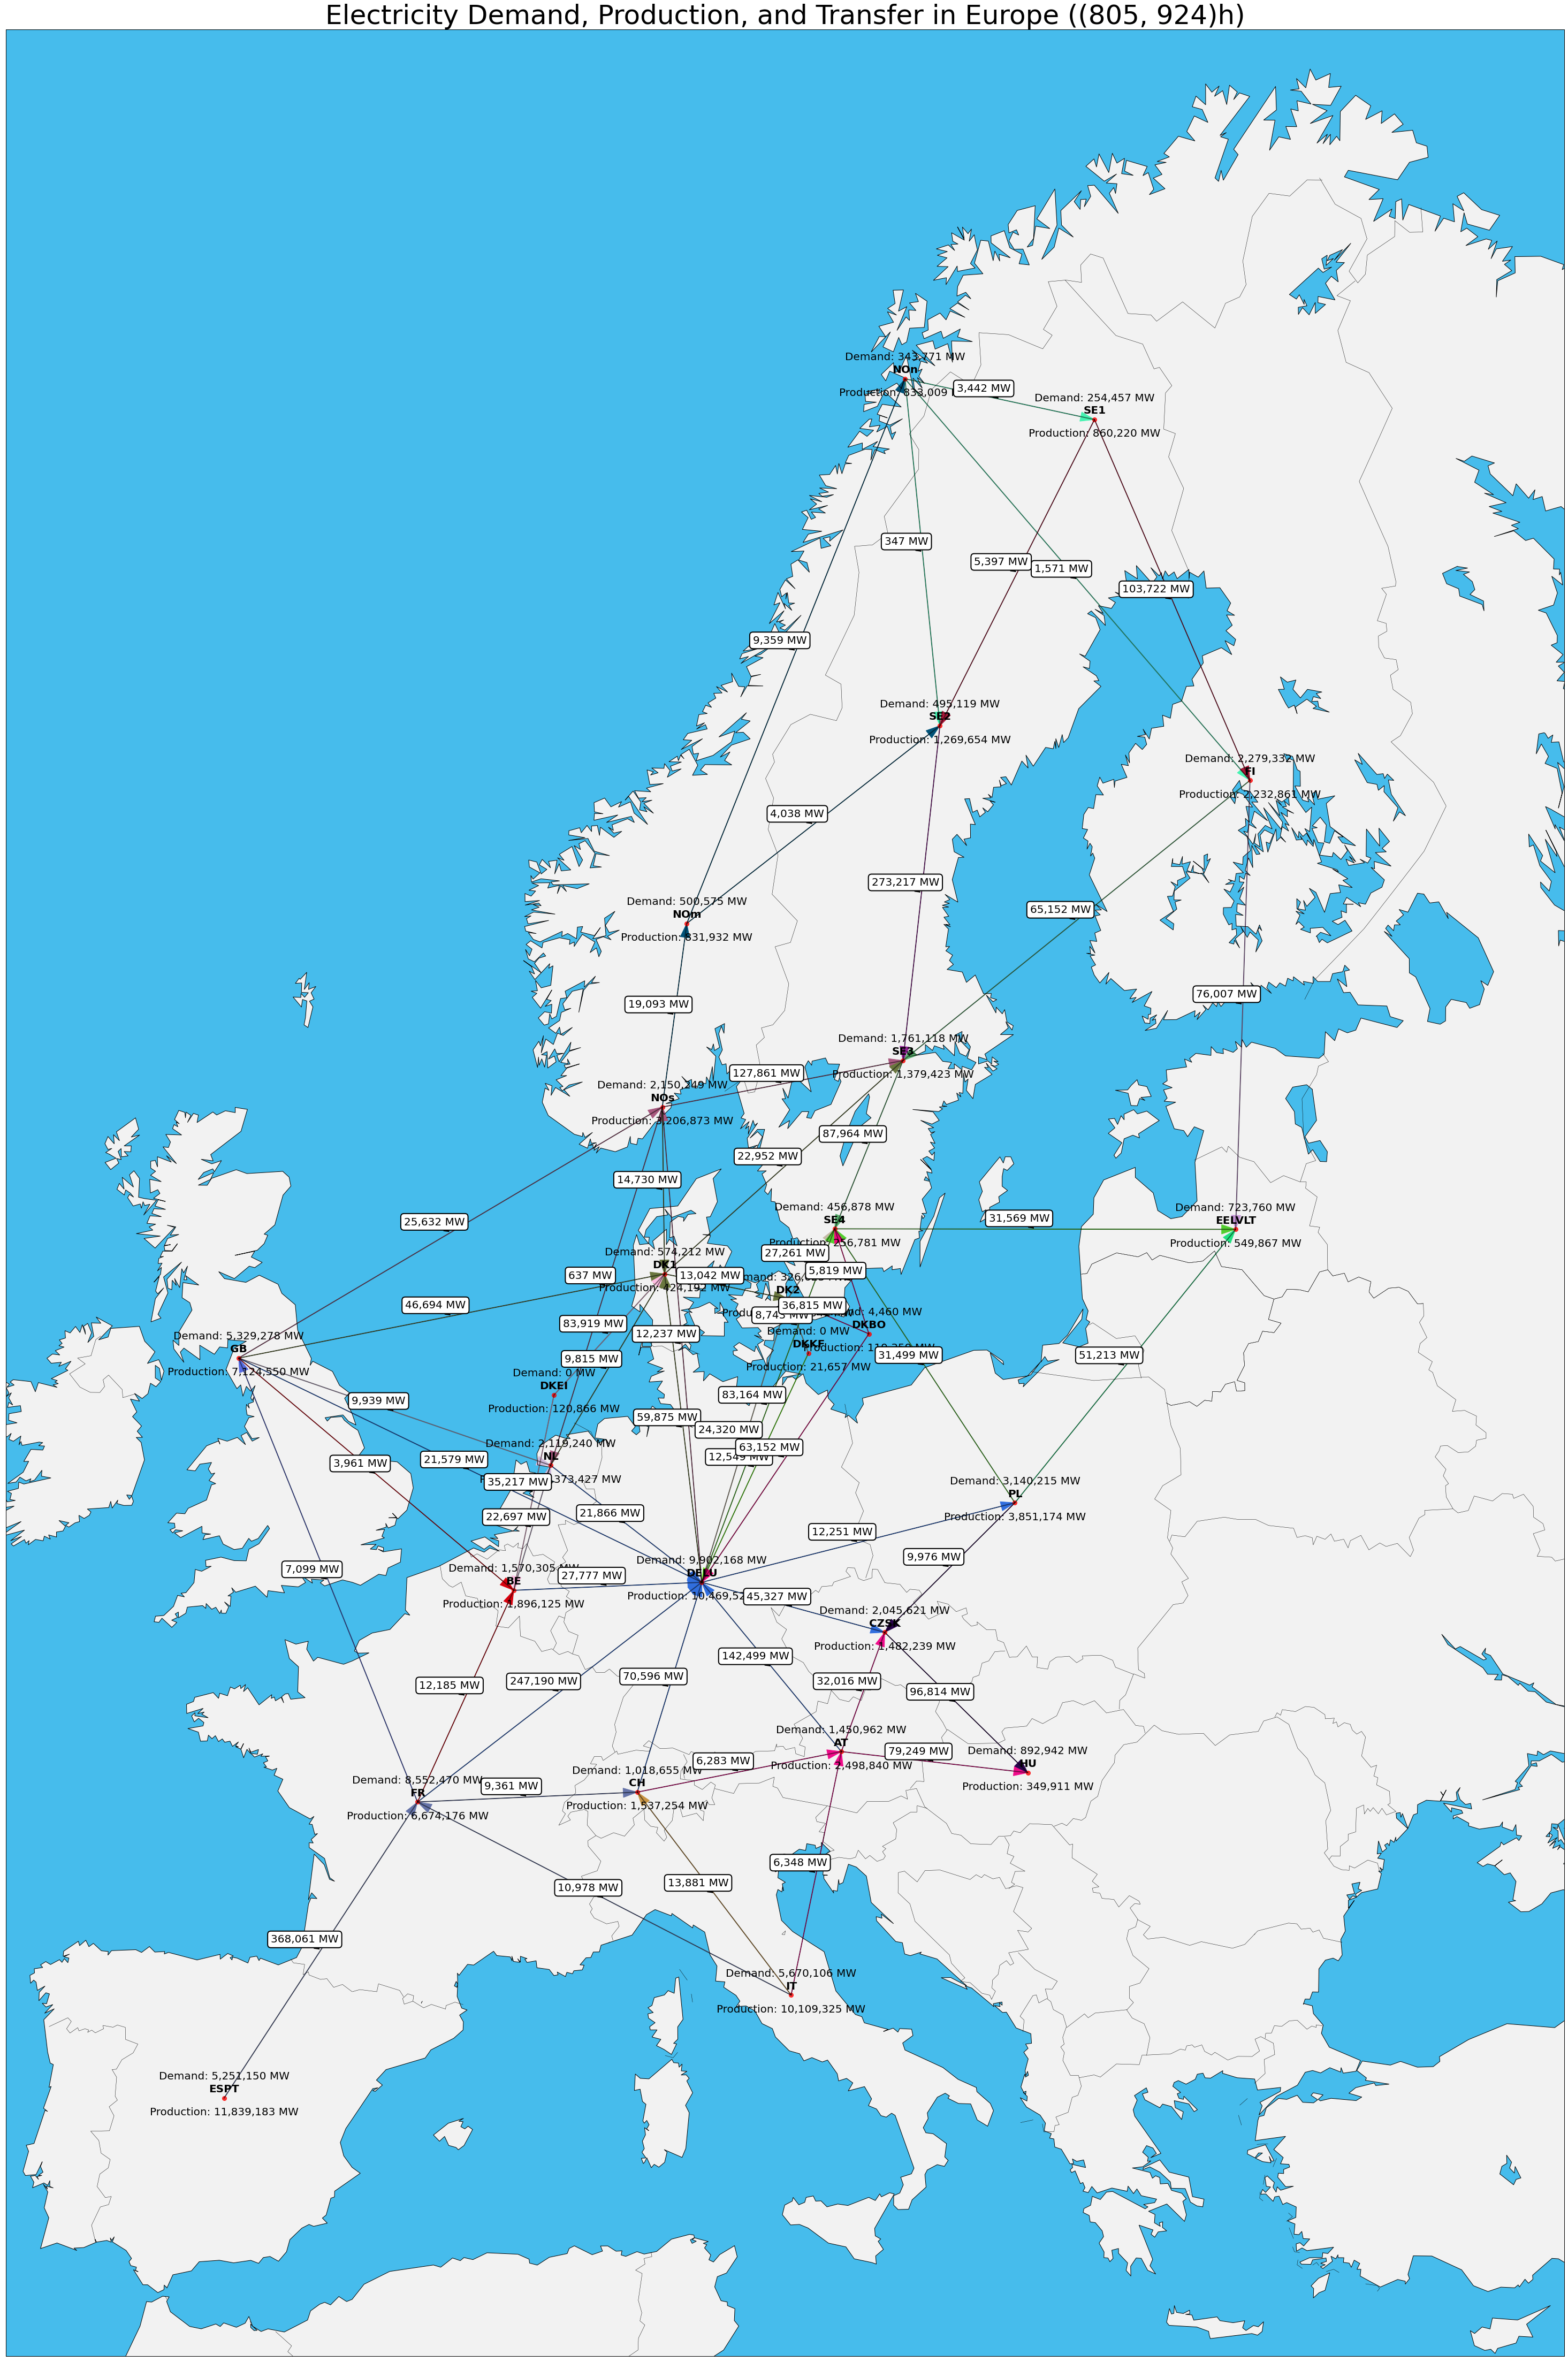

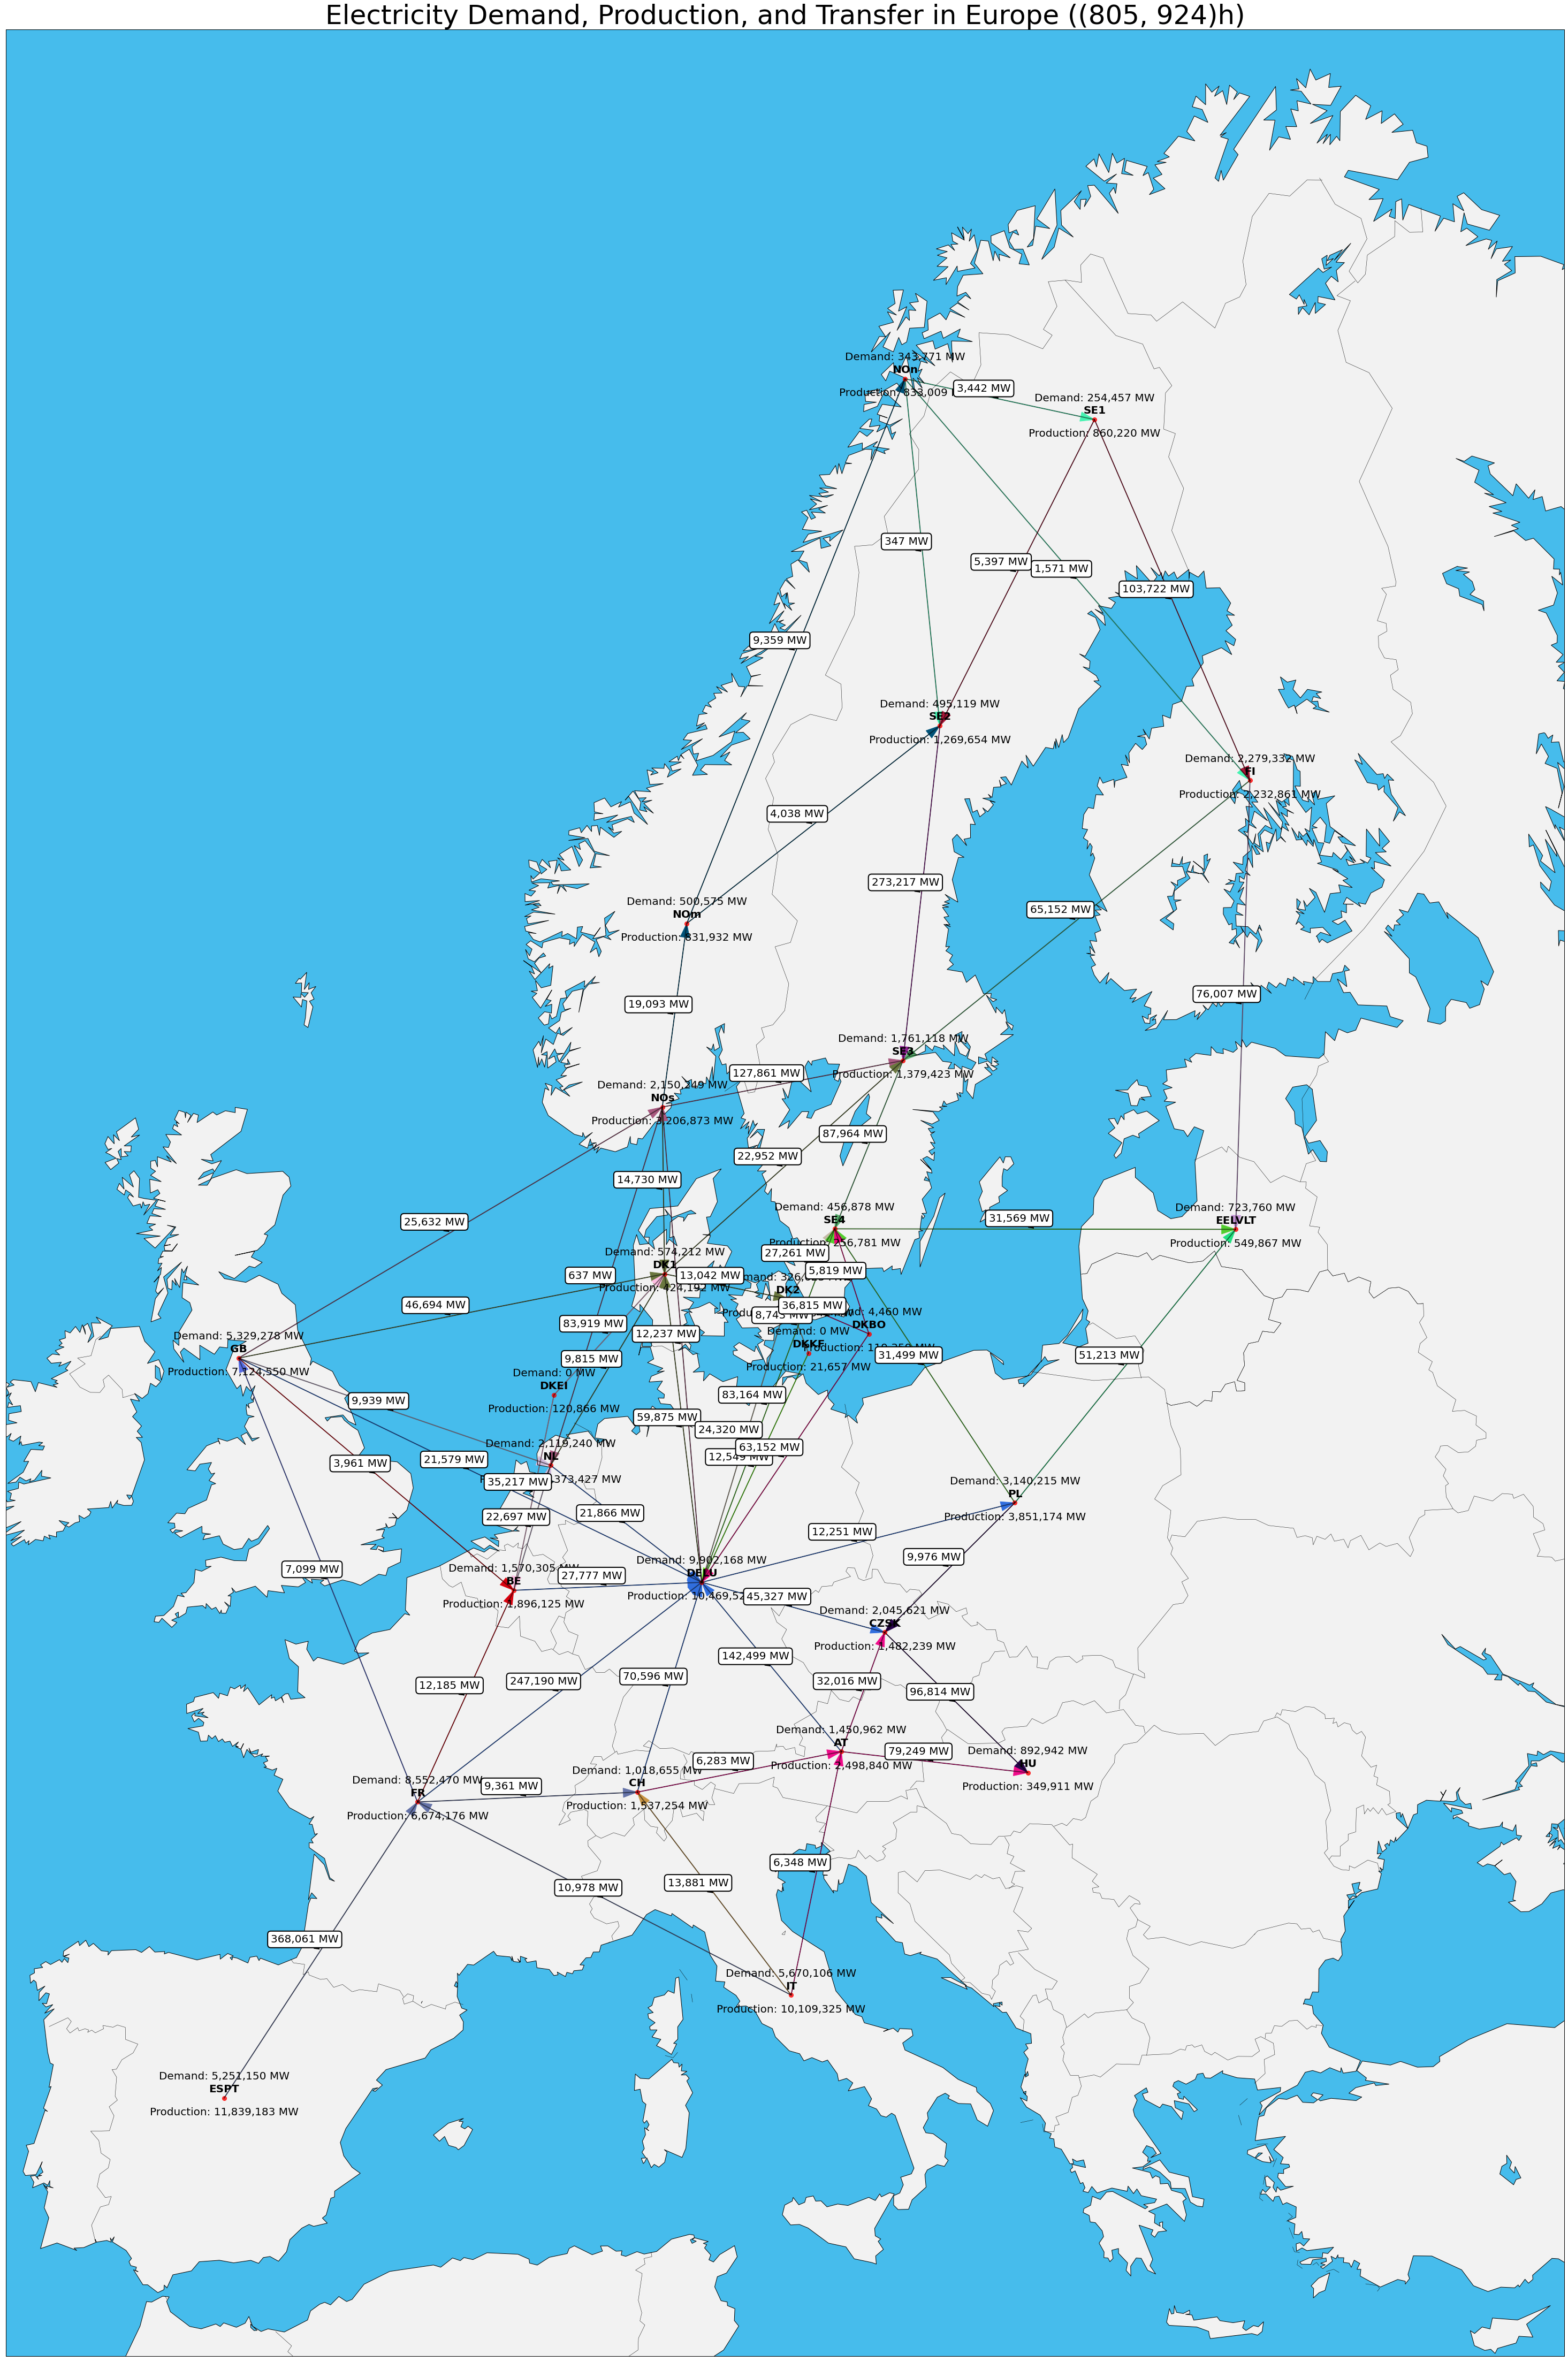

In [9]:
#Her Kaldes funktionen den kan kaldes med nogle forskellige parametre
#Enten kan den kaldes med den enkelt time værdi det kunne feks være plot_network(120) så ville den vise proudktion og
#demand samt import og eksport for hvert land i denne enkle time
#Ellers kan man kalde på det med en tuple værdi. dette vil en periode f.eks. (805-924) er en 120 timers periode (5 dage)
#som så skulle kaldes i funktionen plot_network((805,924)) dette vil give en graf hvor produktion, demand, import og eksport
#summeret for hele periodens længde og så tilføjet til plottet
#Til sidst kan man kalde på funktionen med string 'Total': plot_network('Total') dette vil lave grafen for hele datasættet
#det vil altså summe over produktion, demand, import og eksport fro hvert land for alle 8760 timer
plot_network((805,924))

### Som kan ses kommer der to grafer. Ved ik præcis hvorfor det sker jeg fokusere bare på den øverste men de er vist præcis de samme